# Passages Tutorial
## Introduction
Passages are an object structure that aids in decomposing process mining problems. Using passages, it is possible to decompose event logs and discover subsections of the process model (called net fragments), which is then used to recombine back into a full petri net. Conformance checking can be done in a similar way but backwards. Using the full input model, the net fragment decomposition can be formed by using the passages concept in order to calculate computationally complex alignment problems on far smaller petri nets.

This notebook is designed to go through each step of the process and show exactly what happens in both process discovery and conformance checking.

### Process Discovery Steps:
Input: Event Log, causal structure generation algorithm (c_algo)(OPTIONAL: Custom causal structure can also be inputted, skipping the c_algo), process discovery algorithm (p_algo) 
1. Import Event Log
2. Extend the event log using artificial start and end activities
3. Generate causal structure from the extended event log
4. Generate the minimal passages of the causal structure
5. Generate sublogs based on the visible activities in the passage and the extended event log
6. Generate net fragments based on each of the sublogs
7. Merge all the net fragments into one full petri net

Output: Combined Petri Net

### Conformance Checking Steps:
Input: Petri net model, initial marking, final marking and the event log
1. Import and extend the input model by creating artificial start and end transitions
2. Convert the extended model into a skeleton network (only transitions with edges between them)
3. Get a list of all the silent transition names in the input petri net
4. Generate passages using the skeleton network and use the list of silent transitions to make sure that all silent transitions of the same name end in the same passage
5. Using the information of which transition belongs to which passage, decompose the initial Petri Net into net fragments that contain all the transitions in the passage along with all of the structure between the transitions
6. Using the net fragments and the event log to check the model against, calculate the alignment cost independent of each other
7. Return a combined result of all the individual conformance checking statistics into one output list.

Output: Information about every individual petri net and its conformance statistics


In [1]:
# All imports required for the entire notebook
import pm4py
from pccip.passage_decomp.pd.import_log import import_log
from pccip.passage_decomp.pd.extend_log import extend_log
from pccip.passage_decomp.pd.causal_structure import create_causal_structure
from pccip.passage_decomp.pd.causal_structure import create_custom_causal_structure
from pccip.passage_decomp.passages.min_passages import min_passages
from pccip.passage_decomp.cc.log_decomp import decompose_event_log
from pccip.passage_decomp.pd.net_fragments import create_fragment, merge_fragments
from pccip.passage_decomp.algorithm.process_discovery import passage_process_discovery
from pccip.passage_decomp.cc.import_model import import_petri_net as import_net
from pccip.passage_decomp.cc.extend_model import extend_model as extend_net
from pccip.passage_decomp.utils.transform_skeleton import petri_to_skeleton
from pccip.passage_decomp.cc.net_fragments import create_net_fragments
from pccip.passage_decomp.cc.adapted_cost import adapted_cost_func as alignment_cost
from pccip.passage_decomp.cc.adapted_cost import fragment_fitness as get_fitness
from pccip.passage_decomp.algorithm.constants import ARTIFICIAL_START, ARTIFICIAL_END


## Process Discovery
Tutorial about how process discovery functions using passages. At first, we will explore each of the exact steps and what they do in the algorithm. At the end of the chapter, we try some different parameters by just showing the end result.

### 1. Importing the Event Log
The first function imports the event log from a file if the file name is given, else if the input is already of type EventLog, it simply returns the input again.

In [2]:
file_name = 'figure1.xes'
log = import_log(file_name)

print('Imported event log:')
for trace in log:
    print([x['concept:name'] for x in trace])

parsing log, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

Imported event log:
['a', 'b', 'd', 'e', 'g']
['a', 'c', 'd', 'e', 'f', 'd', 'c', 'e', 'g']
['a', 'c', 'd', 'e', 'h']
['a', 'c', 'd', 'e', 'f', 'd', 'b', 'e', 'g']
['a', 'b', 'd', 'e', 'h']
['a', 'd', 'b', 'e', 'g']
['a', 'd', 'c', 'e', 'g']
['a', 'd', 'c', 'e', 'h']
['a', 'd', 'b', 'e', 'f', 'b', 'd', 'e', 'h']
['a', 'c', 'd', 'e', 'f', 'c', 'd', 'e', 'g']


### 2. Extending the Log
In order for the passage algorithm to work, it is important that there is a well defined start and end transition and place, therefore we extend the initial EventLog with some artificial activities.

In [3]:
ext_log = extend_log(log)

print('Resulting extended event log:')
for trace in ext_log:
    print([x['concept:name'] for x in trace])

Resulting extended event log:
['Artificial:Start', 'a', 'b', 'd', 'e', 'g', 'Artificial:End']
['Artificial:Start', 'a', 'c', 'd', 'e', 'f', 'd', 'c', 'e', 'g', 'Artificial:End']
['Artificial:Start', 'a', 'c', 'd', 'e', 'h', 'Artificial:End']
['Artificial:Start', 'a', 'c', 'd', 'e', 'f', 'd', 'b', 'e', 'g', 'Artificial:End']
['Artificial:Start', 'a', 'b', 'd', 'e', 'h', 'Artificial:End']
['Artificial:Start', 'a', 'd', 'b', 'e', 'g', 'Artificial:End']
['Artificial:Start', 'a', 'd', 'c', 'e', 'g', 'Artificial:End']
['Artificial:Start', 'a', 'd', 'c', 'e', 'h', 'Artificial:End']
['Artificial:Start', 'a', 'd', 'b', 'e', 'f', 'b', 'd', 'e', 'h', 'Artificial:End']
['Artificial:Start', 'a', 'c', 'd', 'e', 'f', 'c', 'd', 'e', 'g', 'Artificial:End']


### 3. Generate the causal structure
Using the causal algorithm similar to the alpha miner OR the heuristics miner, we can generate a causal structure (basically a set of edges) that we would like to consider for valid behaviour and to create passages.

In [4]:
causal = create_causal_structure(ext_log, variant='ALPHA')

print(causal)

{('f', 'c'), ('a', 'c'), ('c', 'e'), ('b', 'e'), ('d', 'e'), ('Artificial:Start', 'a'), ('f', 'd'), ('a', 'd'), ('e', 'h'), ('f', 'b'), ('g', 'Artificial:End'), ('a', 'b'), ('e', 'g'), ('h', 'Artificial:End'), ('e', 'f')}


### 3.5 Custom causal structure
Alternatively, we can also define the causal structure ourselves by just inputting the set of edges we would like to have as valid behaviour. Eg. we could remove the last xor split in the imported event log ('e', 'g') & ('e', 'h'). The custom causal structure will also automatically add all the edges required for the aritifical start and end so that the user must only focus on their event log

In [5]:
causal_input = {('a', 'c'), ('f', 'd'), ('e', 'f'), ('c', 'e'), 
                ('f', 'b'), ('a', 'd'), ('d', 'e'), ('a', 'b'), 
                ('f', 'c'), ('b', 'e')}
causal_custom = create_custom_causal_structure(causal_input, ext_log)

print(causal_custom)

{('f', 'c'), ('c', 'e'), ('a', 'c'), ('b', 'e'), ('d', 'e'), ('Artificial:Start', 'a'), ('f', 'd'), ('a', 'd'), ('f', 'b'), ('a', 'b'), ('e', 'Artificial:End'), ('e', 'f')}


### 4. Generating passages
In order to split the input causal structure into parts that fit with each other, we run a special algorithm to find the passages within the causal structure. Basically, if an edge is (x, y), the minimal passage algorithm collects all edges that have x as its source and y as its target into the same passage. Once there is no more change in a passage, we know that the passage is complete.

In [6]:
passage_set = min_passages(causal)

for i, p in enumerate(passage_set):
    print(f'Passage {i+1}:', p)

Passage 1: X=['a', 'f'], Y=['b', 'c', 'd']
Passage 2: X=['g', 'h'], Y=['Artificial:End']
Passage 3: X=['b', 'c', 'd'], Y=['e']
Passage 4: X=['e'], Y=['f', 'g', 'h']
Passage 5: X=['Artificial:Start'], Y=['a']


### 5. Generating sublogs based on passages
Once we have the passages, we now know which activities belong to which passage and can split the log based on the visible activities. In order to account for loops, we also have to split the looped traces such that each loop is seen as a new trace and unwanted behaviour stays out.

In [7]:
sublogs = set()
for passage in passage_set:
    sublogs.add(decompose_event_log(ext_log, passage.getTVis()))

for slog in sublogs:
    # only showing first 2 traces of each passage sublog
    for trace in slog[:2]:
        print([x['concept:name'] for x in trace])

['g', 'Artificial:End']
['g', 'Artificial:End']
['b', 'd', 'e']
['c', 'd', 'e', 'd', 'c', 'e']
['Artificial:Start', 'a']
['Artificial:Start', 'a']
['e', 'g']
['e', 'f', 'e', 'g']
['a', 'b', 'd']
['a', 'c', 'd', 'f', 'd', 'c']


### 6. Generate net fragments from the sublogs
Now we get to apply either the alpha miner or the inductive miner on the set of passage sublogs. In order for this to work, the traces in the sublog once again have to be split whenever there is a loop in the trace. This is done to account for if the start of the loop is not included in the fragment and includes behaviour that does not exist. Afterwards, we can apply the process discovery variant in order to mine the net fragments

In [8]:
fragments = []
for sublog in sublogs:
    fragments.append(create_fragment(sublog, variant='ALPHA'))

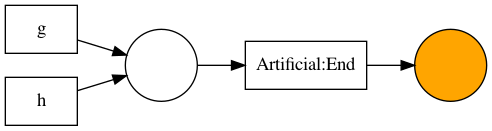

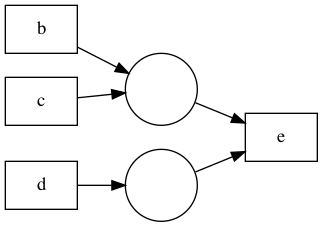

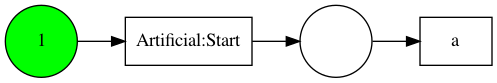

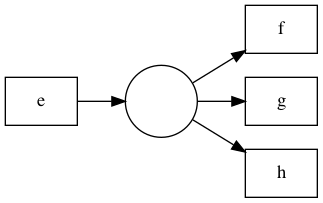

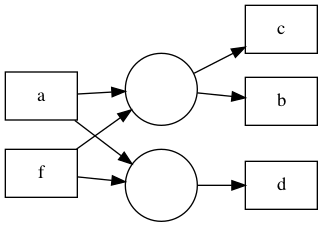

In [9]:
# visualize all of the net fragments individually
for f in fragments:
    pm4py.view_petri_net(f[0], f[1], f[2])

### 7. Merge the net fragments into a complete Petri Net
Finally, once we have all the net fragments, we can combine them at the matching transitions in the model!

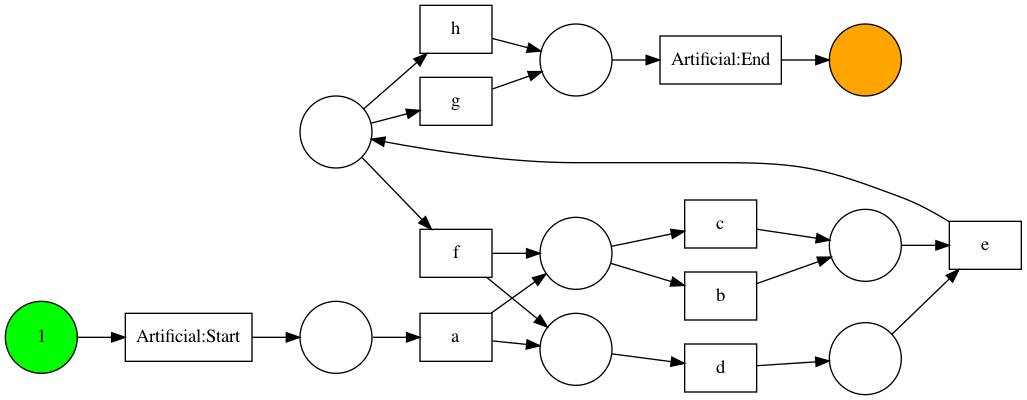

In [10]:
net, im, fm = merge_fragments(fragments)

pm4py.view_petri_net(net, im, fm)

### 7.5 Of course, we can also test out the algorithm on the inductive miner!

parsing log, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

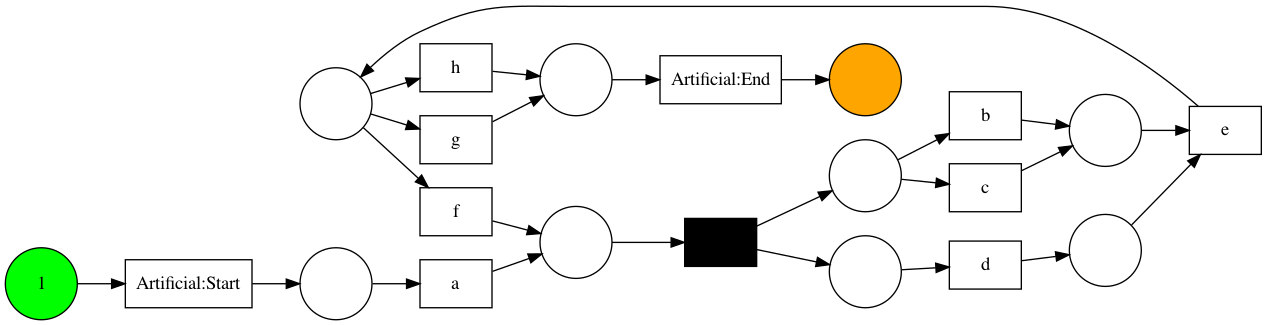

In [11]:
inductive_net, inductive_im, inductive_fm = passage_process_discovery(file_name, p_algo='INDUCTIVE')

pm4py.view_petri_net(inductive_net, inductive_im, inductive_fm)

### BONUS: What about the custom causal structure we created in step 3.5? (No final xOR 'g' and 'h' transitions)

parsing log, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

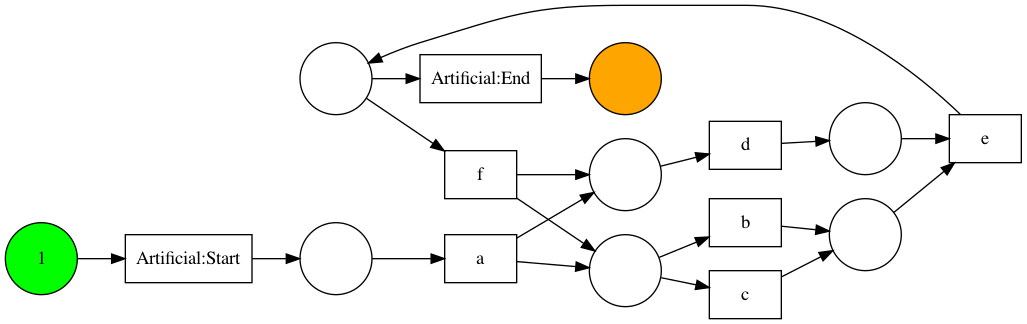

In [12]:
causal_input = {('a', 'c'), ('f', 'd'), ('e', 'f'), ('c', 'e'), 
                ('f', 'b'), ('a', 'd'), ('d', 'e'), ('a', 'b'), 
                ('f', 'c'), ('b', 'e')}
custom_net, custom_im, custom_fm = passage_process_discovery(file_name, c_custom=causal_input)

pm4py.view_petri_net(custom_net, custom_im, custom_fm)

## Conformance Checking

### 1. Importing and extending the Model
In this step we simply import the defined petri net and extend the petri net to include artificial start and end transitions

In [13]:
file_name = 'figure1.pnml'
cc_net, cc_im, cc_fm = import_net(file_name)
ext_net, ext_im, ext_fm = extend_net(cc_net, cc_im, cc_fm)

print('Included Transitions:')
print(ext_net.transitions)
print('------------------------')
print('New edges added:')
print([arc for arc in ext_net.arcs if arc.source.name == ARTIFICIAL_START 
       or arc.target.name == ARTIFICIAL_END])

Included Transitions:
{f, e, g, Artificial:End, h, d, a, b, Artificial:Start, c}
------------------------
New edges added:
[(p)end->(t)Artificial:End, (t)Artificial:Start->(p)start]


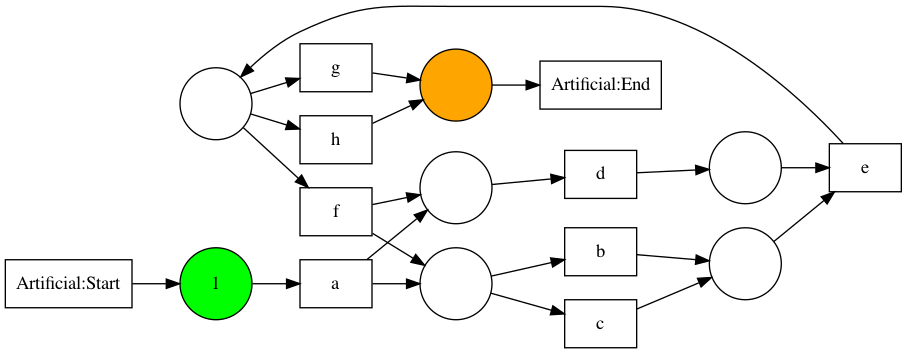

In [14]:
pm4py.view_petri_net(ext_net, ext_im, ext_fm)

### 2. Convert the extended log into a skeleton
The skeleton is similar to the causal structure that was computed in the process discovery section of passages. It includes all edges that are between transitions (basically translating the place behaviour into direct arcs between transitions)

In [15]:
skeleton = petri_to_skeleton(ext_net)
for edge in skeleton.edges:
    print(f'Edge from {edge[0]} to {edge[1]}. ------------------ ie. ({edge[0]}, {edge[1]})')

Edge from d to e. ------------------ ie. (d, e)
Edge from e to g. ------------------ ie. (e, g)
Edge from e to h. ------------------ ie. (e, h)
Edge from e to f. ------------------ ie. (e, f)
Edge from Artificial:Start to a. ------------------ ie. (Artificial:Start, a)
Edge from a to c. ------------------ ie. (a, c)
Edge from a to b. ------------------ ie. (a, b)
Edge from a to d. ------------------ ie. (a, d)
Edge from c to e. ------------------ ie. (c, e)
Edge from b to e. ------------------ ie. (b, e)
Edge from f to c. ------------------ ie. (f, c)
Edge from f to b. ------------------ ie. (f, b)
Edge from f to d. ------------------ ie. (f, d)
Edge from h to Artificial:End. ------------------ ie. (h, Artificial:End)
Edge from g to Artificial:End. ------------------ ie. (g, Artificial:End)


### 3. Get a list of all transition names in the input petri net
This step is important as the output is used to make the min_passages algorithm very efficient. By knowing which transitions in the skeleton are silent, we can easily include all the silent transitions of the same name into the same passage.

In [16]:
silent_transitions = {tran.name for tran in ext_net.transitions if not tran.label}
print(f'Set of silent transitions names in the petri net: {silent_transitions}')

Set of silent transitions names in the petri net: set()


### 4. Generate the passages using the skeleton and the list of silent transitions as input


In [17]:
passage_set = min_passages(skeleton, silent_transitions)

for i, p in enumerate(passage_set):
    print(f'Passage {i+1}:', p)

Passage 1: X=['a', 'f'], Y=['b', 'c', 'd']
Passage 2: X=['g', 'h'], Y=['Artificial:End']
Passage 3: X=['b', 'c', 'd'], Y=['e']
Passage 4: X=['e'], Y=['f', 'g', 'h']
Passage 5: X=['Artificial:Start'], Y=['a']


### 5. Using the passages, decompose the extended model into the minimal net fragments
Using the knowledge of which transition belonging to which passage, we can decompose the event log into the individual net fragments. Because we encoded the petri net information into the passage, we can simply retrieve all the model data using a simple dictionary lookup in the digraph_link dictionary inside of the passage.

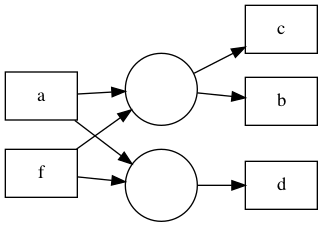

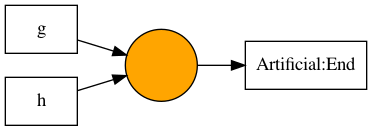

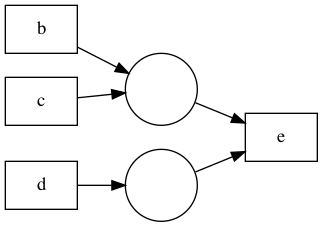

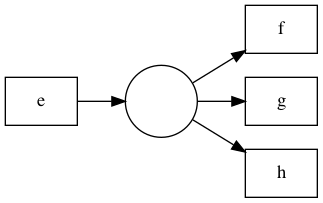

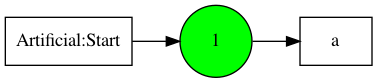

In [18]:
fragment_list = create_net_fragments(passage_set)

for f in fragment_list:
    pm4py.view_petri_net(f[0], f[1], f[2])

### 6. Check the alignment cost for each of the fragments individually using sublogs of the input event log

In [19]:
test_log = import_log('figure1.xes')
fragment_cost = alignment_cost(test_log, fragment_list)

for k, v in fragment_cost[0].items():
    print(f'passage {k+1} alignments: {[result["alignment"] for result in v]}')
    print(f'cost of passage {k+1} on log: {fragment_cost[1][k]}')
    print('-----------------------------------------')

parsing log, completed traces ::   0%|          | 0/10 [00:00<?, ?it/s]

passage 1 alignments: [[('a', 'a'), ('b', 'b'), ('d', 'd')], [('a', 'a'), ('c', 'c'), ('d', 'd'), ('f', 'f')], [('a', 'a'), ('c', 'c'), ('d', 'd')], [('a', 'a'), ('c', 'c'), ('d', 'd'), ('f', 'f'), ('b', 'b')], [('a', 'a'), ('b', 'b'), ('d', 'd')], [('a', 'a'), ('d', 'd'), ('b', 'b')], [('a', 'a'), ('d', 'd'), ('c', 'c')], [('a', 'a'), ('d', 'd'), ('c', 'c')], [('a', 'a'), ('d', 'd'), ('b', 'b'), ('f', 'f')], [('a', 'a'), ('c', 'c'), ('d', 'd'), ('f', 'f')]]
cost of passage 1 on log: 0
-----------------------------------------
passage 2 alignments: [[('g', 'g')], [('g', 'g')], [('h', 'h')], [('g', 'g')], [('h', 'h')], [('g', 'g')], [('g', 'g')], [('h', 'h')], [('h', 'h')], [('g', 'g')]]
cost of passage 2 on log: 0
-----------------------------------------
passage 3 alignments: [[('b', 'b'), ('d', 'd'), ('e', 'e')], [('c', 'c'), ('d', 'd'), ('e', 'e')], [('c', 'c'), ('d', 'd'), ('e', 'e')], [('c', 'c'), ('d', 'd'), ('e', 'e'), ('b', 'b')], [('b', 'b'), ('d', 'd'), ('e', 'e')], [('d', 'd

### 7. Using the alignment cost for each of the passages, we can finally compute the fitness values for each of the local passages

In [20]:
overall_fitness = get_fitness(fragment_cost[0])

for k, v in overall_fitness.items():
    print(f'Passage {k+1}: Fitting Trace %age: {v["percFitTraces"]}, Avg. Fitness: {v["averageFitness"]}')

Passage 1: Fitting Trace %age: 100.0, Avg. Fitness: 1.0
Passage 2: Fitting Trace %age: 100.0, Avg. Fitness: 1.0
Passage 3: Fitting Trace %age: 100.0, Avg. Fitness: 1.0
Passage 4: Fitting Trace %age: 100.0, Avg. Fitness: 1.0
Passage 5: Fitting Trace %age: 100.0, Avg. Fitness: 1.0
